Using device: cuda


Epoch 1/15: 100%|██████████| 1151/1151 [04:59<00:00,  3.84it/s]


Epoch 1/15 | Train Loss: 0.5065 | Val Loss: 0.4567 | Val Acc: 0.7920


Epoch 2/15: 100%|██████████| 1151/1151 [05:42<00:00,  3.36it/s]


Epoch 2/15 | Train Loss: 0.4496 | Val Loss: 0.4628 | Val Acc: 0.7961


Epoch 3/15: 100%|██████████| 1151/1151 [06:36<00:00,  2.91it/s] 


Epoch 3/15 | Train Loss: 0.4253 | Val Loss: 0.4278 | Val Acc: 0.8095


Epoch 4/15: 100%|██████████| 1151/1151 [04:54<00:00,  3.91it/s]


Epoch 4/15 | Train Loss: 0.4069 | Val Loss: 0.4315 | Val Acc: 0.8145


Epoch 5/15: 100%|██████████| 1151/1151 [04:57<00:00,  3.87it/s]


Epoch 5/15 | Train Loss: 0.3867 | Val Loss: 0.4390 | Val Acc: 0.8101


Epoch 6/15: 100%|██████████| 1151/1151 [04:56<00:00,  3.88it/s]


Epoch 6/15 | Train Loss: 0.3721 | Val Loss: 0.4674 | Val Acc: 0.8089


Epoch 7/15: 100%|██████████| 1151/1151 [05:28<00:00,  3.50it/s]


Epoch 7/15 | Train Loss: 0.3576 | Val Loss: 0.4553 | Val Acc: 0.8101


Epoch 8/15: 100%|██████████| 1151/1151 [05:43<00:00,  3.35it/s]


Epoch 8/15 | Train Loss: 0.3433 | Val Loss: 0.4681 | Val Acc: 0.8139


Epoch 9/15: 100%|██████████| 1151/1151 [05:44<00:00,  3.34it/s]


Epoch 9/15 | Train Loss: 0.3278 | Val Loss: 0.4721 | Val Acc: 0.8151


Epoch 10/15: 100%|██████████| 1151/1151 [05:52<00:00,  3.27it/s]


Epoch 10/15 | Train Loss: 0.3075 | Val Loss: 0.4985 | Val Acc: 0.8092


Epoch 11/15: 100%|██████████| 1151/1151 [05:01<00:00,  3.82it/s]


Epoch 11/15 | Train Loss: 0.2961 | Val Loss: 0.5181 | Val Acc: 0.8108


Epoch 12/15: 100%|██████████| 1151/1151 [05:05<00:00,  3.77it/s]


Epoch 12/15 | Train Loss: 0.2819 | Val Loss: 0.5069 | Val Acc: 0.8095


Epoch 13/15: 100%|██████████| 1151/1151 [05:05<00:00,  3.77it/s]


Epoch 13/15 | Train Loss: 0.2612 | Val Loss: 0.5425 | Val Acc: 0.7979


Epoch 14/15: 100%|██████████| 1151/1151 [05:05<00:00,  3.77it/s]


Epoch 14/15 | Train Loss: 0.2545 | Val Loss: 0.5400 | Val Acc: 0.8183


Epoch 15/15: 100%|██████████| 1151/1151 [04:50<00:00,  3.96it/s]


Epoch 15/15 | Train Loss: 0.2372 | Val Loss: 0.5559 | Val Acc: 0.8073

Classification Metrics:
    Accuracy  Precision    Recall  F1-Score
0  0.807319   0.878311  0.693464  0.775018


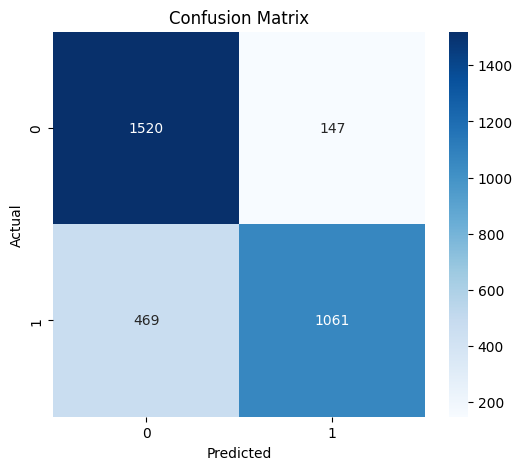

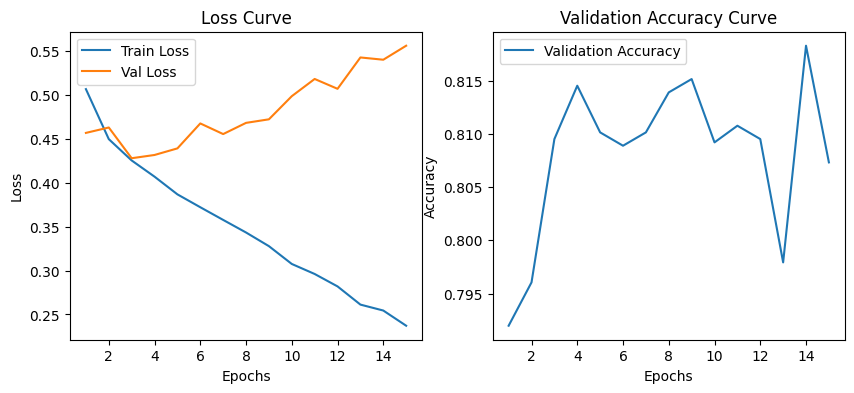

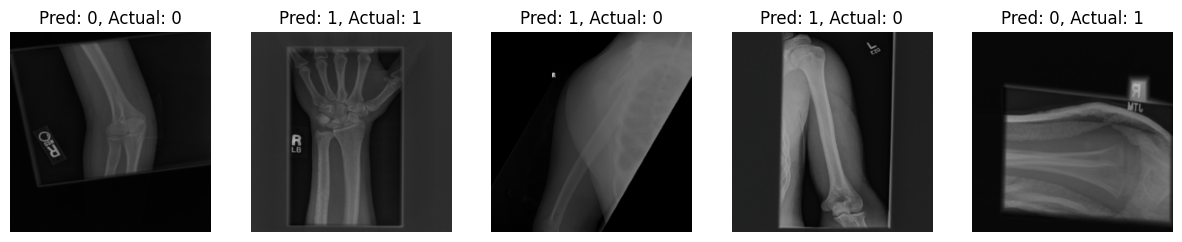

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import MobileNet_V2_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# -----------------------------
# Step 1: Device Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Step 2: Dataset Class
# -----------------------------
class MURADataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0].replace("\\", "/")  # fix slashes
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# -----------------------------
# Step 3: Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -----------------------------
# Step 4: Load Data
# -----------------------------
train_dataset = MURADataset("Datasets/MURA-v1.1/train_complete_path_images.csv", transform=train_transform)
valid_dataset = MURADataset("Datasets/MURA-v1.1/valid_complete_path_images.csv", transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# -----------------------------
# Step 5: MobileNetV2 Model
# -----------------------------
mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Fine-tune all layers
for param in mobilenet.parameters():
    param.requires_grad = True

# Replace classifier for binary classification
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(mobilenet.last_channel, 1),
    nn.Sigmoid()
)

model = mobilenet.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# LR scheduler: Reduce LR when validation metric plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

# -----------------------------
# Step 6: Training Loop
# -----------------------------
num_epochs = 15
train_losses, val_losses, val_accs = [], [], []
best_val_acc = 0
best_model_path = "mobilenetv2_best.pth"

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True):
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    y_true, y_pred = [], []
    val_loss = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs > 0.5).int()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    val_loss = val_loss / len(valid_loader)
    val_losses.append(val_loss)
    acc = accuracy_score(y_true, y_pred)
    val_accs.append(acc)

    # Scheduler step and print LR changes
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(acc)
    new_lr = optimizer.param_groups[0]['lr']
    if old_lr != new_lr:
        print(f"Learning rate changed: {old_lr:.6f} -> {new_lr:.6f}")

    # Save best model
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.4f}")

# -----------------------------
# Step 7: Metrics Table
# -----------------------------
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [precision],
    "Recall": [recall],
    "F1-Score": [f1]
})
print("\nClassification Metrics:\n", metrics_df)

# -----------------------------
# Step 8: Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# Step 9: Loss & Accuracy Graphs
# -----------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1,num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(range(1,num_epochs+1), val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy Curve")
plt.show()

# -----------------------------
# Step 10: Test Some Images
# -----------------------------
test_dataset = MURADataset("Datasets/MURA-v1.1/valid_complete_path_images.csv", transform=valid_transform)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
preds = (outputs > 0.5).int()

# Display images with predictions
plt.figure(figsize=(15,5))
for i in range(len(images)):
    img = images[i].cpu().permute(1,2,0)  # C,H,W -> H,W,C
    img = img * torch.tensor([0.229,0.224,0.225]) + torch.tensor([0.485,0.456,0.406])
    img = img.numpy()
    plt.subplot(1,len(images),i+1)
    plt.imshow(img)
    plt.title(f"Pred: {preds[i].item()}, Actual: {labels[i].item()}")
    plt.axis("off")
plt.show()
